<h1 style="padding: 10px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:180%"><b> Imports </b></h1>

In [38]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import lightgbm as lgb
from catboost import CatBoostClassifier

import keras_tuner as kt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional, 
    Dropout, 
    BatchNormalization, 
    TimeDistributed, 
    RepeatVector, 
    Conv2D, 
    MaxPooling2D, 
    UpSampling2D, 
    Reshape
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

warnings.filterwarnings('ignore')

<h1 style="padding: 10px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:180%"><b>Datasets </b></h1>

## 1. Load the processed dataset

In [39]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cic-ids-version-2/cic-ids (1).csv


In [40]:
# Load the processed dataset
CICIDS_data = pd.read_csv('/kaggle/input/cic-ids-version-2/cic-ids (1).csv')

# Optionally display the sampled data
print("Dataset overview:")
display(CICIDS_data.head())
display(CICIDS_data.info())

# Display the distribution of the "Label" column
label_distribution = CICIDS_data['Label'].value_counts()
print("Distribution of 'Label' column:")
print(label_distribution)

Dataset overview:


,Dst Port,Protocol,Fwd Pkt Len Min,Fwd Pkt Len Std,Bwd Pkt Len Min,Flow Byts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Min,Fwd IAT Std,...,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Std,Active Max,Active Min,Idle Std,Idle Max,Idle Min,Label
0,443,6,0,23.197906,46,2.336263,1.396461e+07,2.578900e+07,22,2.875936e+07,...,127,3,20,30373.771786,206637,163682,4.067040e+06,58549010,52797347,0
1,80,6,0,48.500000,0,60.224085,7.780466e+05,2.031246e+06,38,3.557089e+04,...,141,1,20,0.000000,0,0,0.000000e+00,0,0,0
2,80,6,0,0.000000,0,0.000000,9.200000e+01,0.000000e+00,92,0.000000e+00,...,-1,0,20,0.000000,0,0,0.000000e+00,0,0,0
3,2111,6,0,0.000000,0,0.000000,8.617436e+07,0.000000e+00,86174361,0.000000e+00,...,-1,0,20,0.000000,0,0,0.000000e+00,86174361,86174361,0
4,443,6,0,42.723920,126,6.628966,1.206825e+07,2.675886e+07,29581,3.448696e+07,...,8118,1,20,0.000000,77775,77775,0.000000e+00,59935597,59935597,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115500 entries, 0 to 115499
Data columns (total 38 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           115500 non-null  int64  
 1   Protocol           115500 non-null  int64  
 2   Fwd Pkt Len Min    115500 non-null  int64  
 3   Fwd Pkt Len Std    115500 non-null  float64
 4   Bwd Pkt Len Min    115500 non-null  int64  
 5   Flow Byts/s        115500 non-null  float64
 6   Flow IAT Mean      115500 non-null  float64
 7   Flow IAT Std       115500 non-null  float64
 8   Flow IAT Min       115500 non-null  int64  
 9   Fwd IAT Std        115500 non-null  float64
 10  Bwd IAT Std        115500 non-null  float64
 11  Bwd IAT Max        115500 non-null  int64  
 12  Bwd IAT Min        115500 non-null  int64  
 13  Fwd PSH Flags      115500 non-null  int64  
 14  Fwd URG Flags      115500 non-null  int64  
 15  Bwd Header Len     115500 non-null  int64  
 16  Bw

None

Distribution of 'Label' column:
Label
0     10500
1     10500
2     10500
3     10500
4     10500
5     10500
6     10500
7     10500
8     10500
9     10500
10    10500
Name: count, dtype: int64


<h1 style="padding: 10px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:180%"><b> Splitting the dataset into train and test </b></h1>

In [41]:
# Separate features and target variable
X = CICIDS_data.drop(columns=['Label'])  # Features 
y = CICIDS_data['Label']  # Target column

# Convert target variable to categorical
y_categorical = to_categorical(y)

# Split the dataset into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Displaying the shapes of the resulting datasets
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (92400, 37)
Shape of X_test: (23100, 37)
Shape of y_train: (92400, 11)
Shape of y_test: (23100, 11)


<h1 style="padding: 10px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:180%"><b> Training and Evaluating Supervised ML Models </b></h1>

## 1. K-Nearest Neighbors (KNN)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validated accuracy:  0.8740584415584415
Accuracy: 0.8801731601731602
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.65      0.66      2115
           1       1.00      1.00      1.00      2134
           2       1.00      1.00      1.00      2104
           3       0.98      0.98      0.98      2125
           4       0.98      0.98      0.98      2076
           5       0.99      1.00      0.99      2178
           6       0.82      0.54      0.65      2175
           7       1.00      0.99      0.99      2084
           8       0.64      0.88      0.74      2061
           9       0.65      0.67      0.66      2023
          10       1.00      1.00      1.00      2025

    accuracy                           0.88     23100
   macro avg       0.88      0.88      0.88

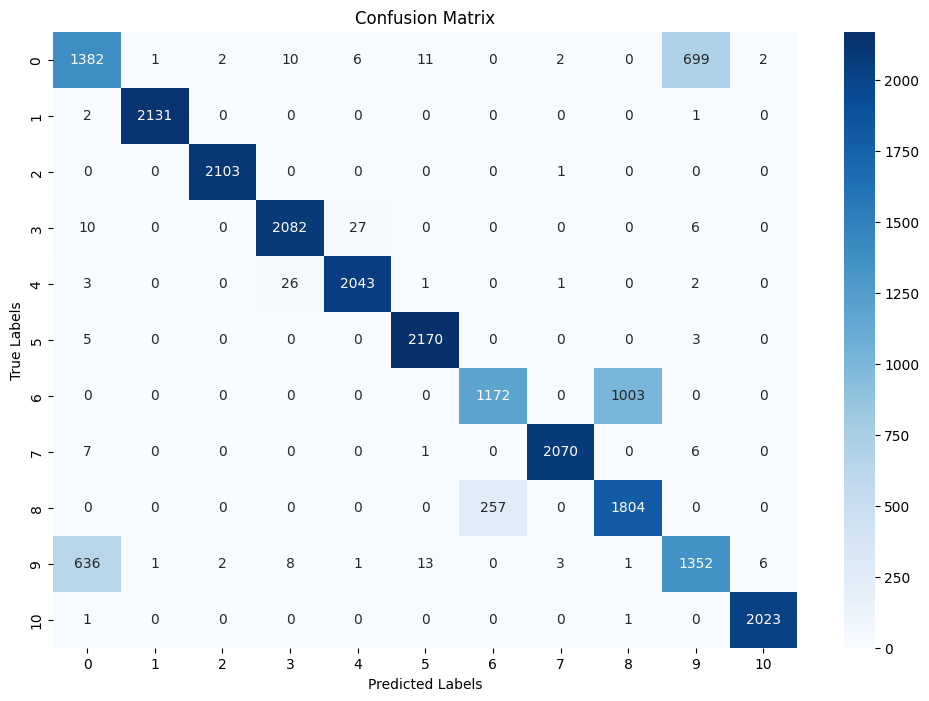

Model saved as 'best_knn_model.pkl'


In [21]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3,5,7],  # Selected n_neighbors
    'weights': ['distance'],  # Selected weight option
    'metric': ['euclidean']  # Selected distance metric
}

# Initialize the KNN model
knn_model = KNeighborsClassifier()

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model to the training data using grid search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_knn_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated accuracy: ", grid_search.best_score_)

# Make predictions on the test data
y_pred = best_knn_model.predict(X_test)

# Since y_pred contains probabilities, take the index of the max probability
y_pred_classes = y_pred.argmax(axis=1)

# Convert y_test back to class labels from categorical
y_test_classes = y_test.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the best model to a file
joblib.dump(best_knn_model, 'best_knn_model.pkl')
print("Model saved as 'best_knn_model.pkl'")

## 2. Decision Tree

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   3.0s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   3.0s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   2.9s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   2.9s
[CV] END criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   3.0s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   3.1s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   3.0s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=2, min_samples_split=5, splitter=best; total time=   3.2s
[CV]

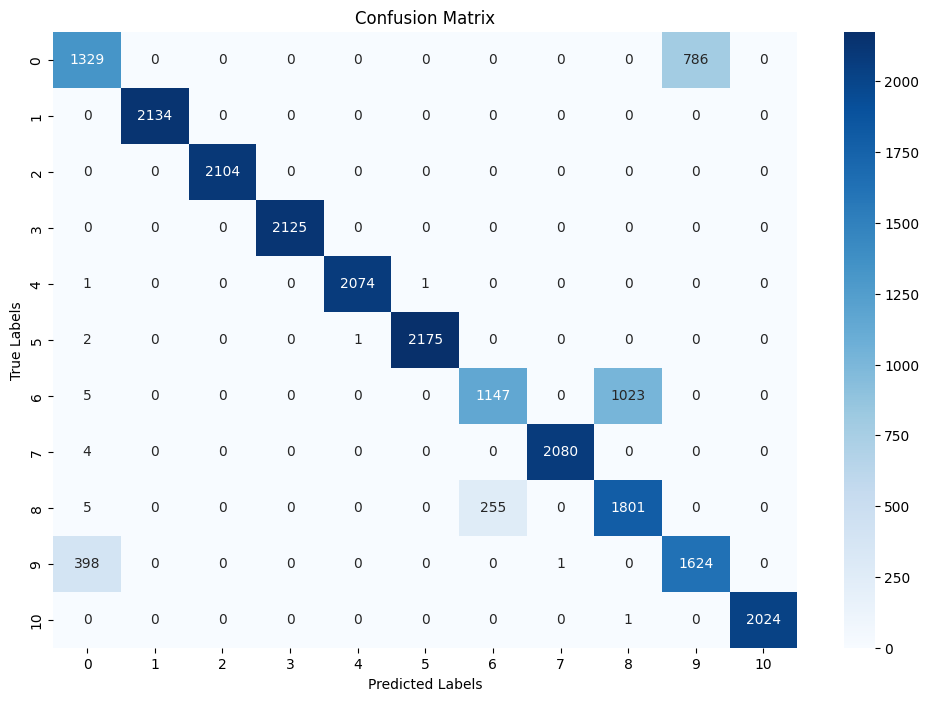

Model saved as 'best_dt_model.pkl'


In [25]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['entropy'],  # Selected criterion
    'splitter': ['best'],      # Selected splitter
    'max_depth': [20,30],         # Selected max depth
    'min_samples_split': [5],  # Selected min samples to split
    'min_samples_leaf': [2]    # Selected min samples at leaf
}

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model to the training data using grid search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_dt_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated accuracy: ", grid_search.best_score_)

# Make predictions on the test data
y_pred = best_dt_model.predict(X_test)

# Since y_pred contains probabilities, take the index of the max probability
y_pred_classes = y_pred.argmax(axis=1)

# Convert y_test back to class labels from categorical
y_test_classes = y_test.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the best model to a file
joblib.dump(best_dt_model, 'best_dt_model.pkl')
print("Model saved as 'best_dt_model.pkl'")

## 3. Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 150}
Best cross-validated accuracy:  0.8946428571428573
Accuracy: 0.8957575757575758
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.73      2115
           1       1.00      1.00      1.00      2134
           2       1.00      1.00      1.00      2104
           3       1.00      1.00      1.00      2125
           4       1.00      1.00      1.00      2076
           5       1.00      1.00      1.00      2178
           6       0.82      0.53      0.64      2175
           7       1.00      1.00      1.00      2084
           8       0.64      0.87      0.74      2061
           9       0.71      0.75      0.73      2023
          10       1.00      1.00      1.00      2025

    accuracy                           0.90     23100
   macro avg      

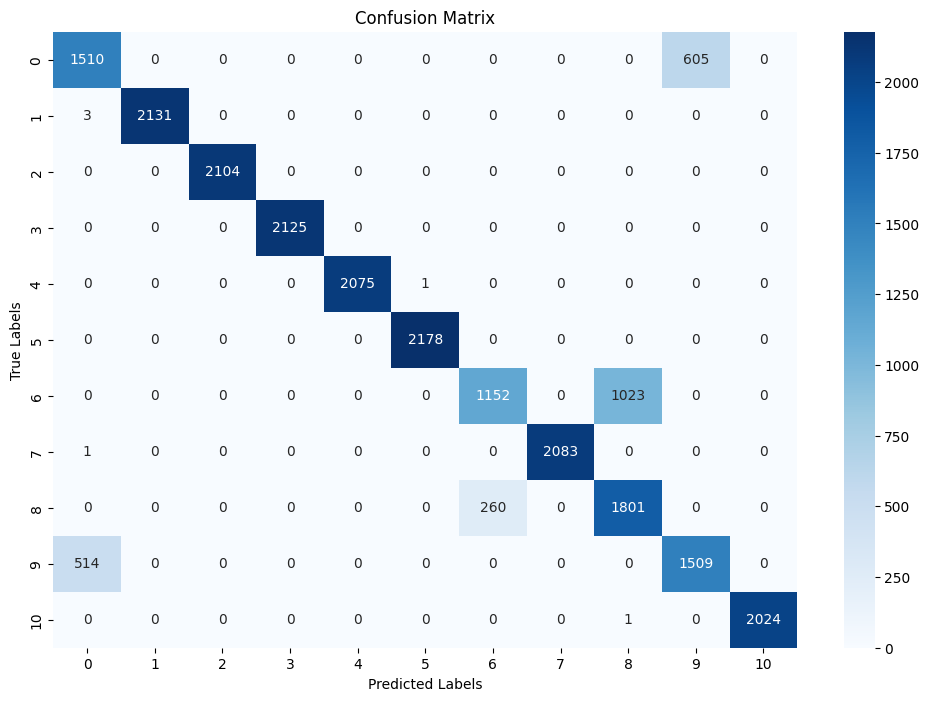

Model saved as 'best_rf_model.pkl'


In [31]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [150],                     # Selected number of trees
    'max_depth': [20],                         # Selected max depth
    'min_samples_split': [5],                  # Selected min samples to split
    'class_weight': ['balanced']                # Selected class weights
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model to the training data using grid search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated accuracy: ", grid_search.best_score_)

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

# Since y_pred contains probabilities, take the index of the max probability
y_pred_classes = y_pred.argmax(axis=1)

# Convert y_test back to class labels from categorical
y_test_classes = y_test.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the best model to a file
joblib.dump(best_rf_model, 'best_rf_model.pkl')
print("Model saved as 'best_rf_model.pkl'")

## 4. XGBoost Model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validated accuracy:  0.8881601731601731
Accuracy: 0.8954978354978355
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74      2115
           1       1.00      1.00      1.00      2134
           2       1.00      1.00      1.00      2104
           3       1.00      1.00      1.00      2125
           4       1.00      1.00      1.00      2076
           5       1.00      1.00      1.00      2178
           6       0.81      0.53      0.64      2175
           7       1.00      1.00      1.00      2084
           8       0.64      0.87      0.74      2061
           9       0.73      0.70      0.72      2023
          10       1.00      1.00      1.00      2025

    accuracy                           0.90     23100
   mac

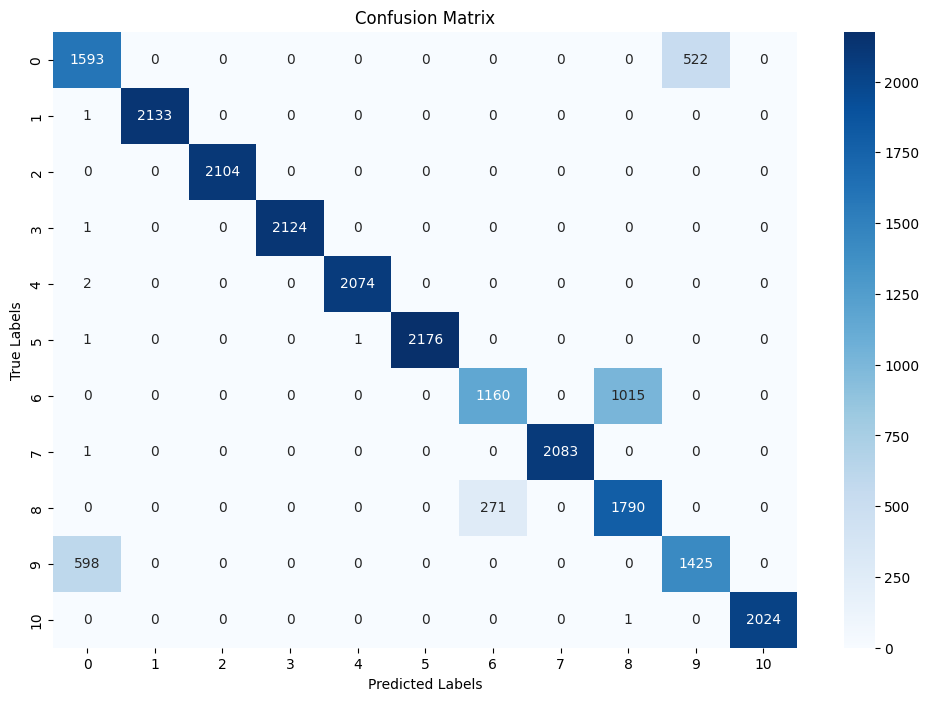

Model saved as 'best_xgb_model.pkl'


In [26]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [200],                     # Selected number of trees
    'max_depth': [9],                          # Selected max depth
    'learning_rate': [0.1],                    # Selected learning rate
    'subsample': [0.9],                        # Selected subsample ratio
    'colsample_bytree': [0.8]                  # Selected column sample ratio
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model to the training data using grid search
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated accuracy: ", grid_search.best_score_)

# Make predictions on the test data
y_pred = best_xgb_model.predict(X_test)

# Since y_pred contains probabilities, take the index of the max probability
y_pred_classes = y_pred.argmax(axis=1)

# Convert y_test back to class labels from categorical
y_test_classes = y_test.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the best model to a file
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')
print("Model saved as 'best_xgb_model.pkl'")

## 5. LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6134
[LightGBM] [Info] Number of data points in the train set: 92400, number of used features: 37
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start tra

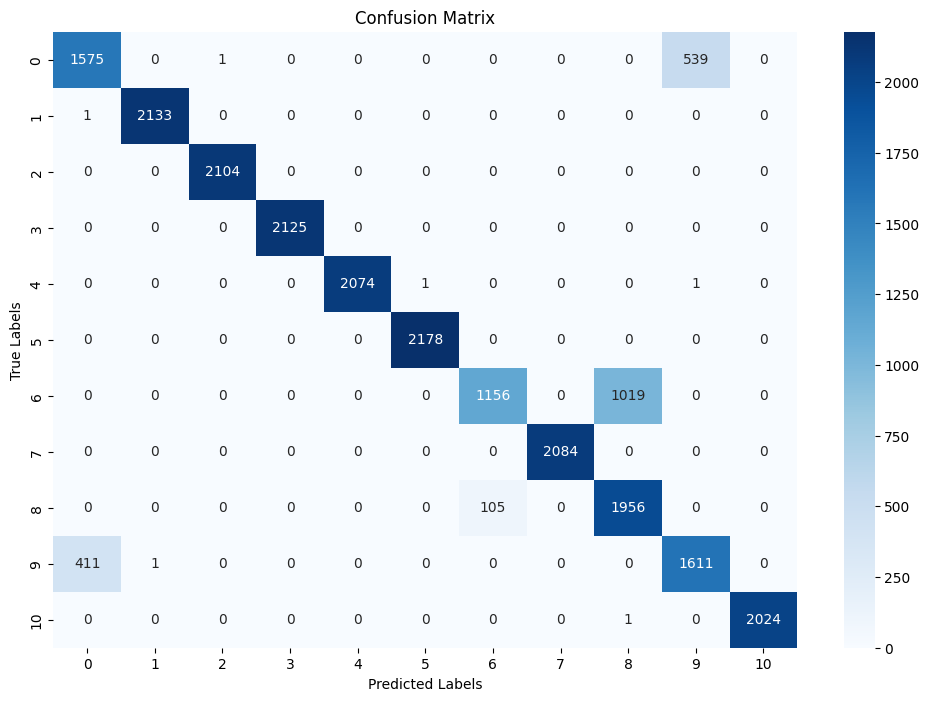

Model saved as 'best_lgb_model.pkl'


In [42]:
# Initialize the LightGBM model with specified hyperparameters
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,           # Number of boosting rounds
    learning_rate=0.05,         # Step size for each boosting round
    max_depth=-1,               # Maximum depth of each tree (default is unlimited)
    num_leaves=31,              # Maximum number of leaves in one tree
    colsample_bytree=0.8,       # Fraction of features to consider at each split
    subsample=0.8,              # Fraction of samples to use for each tree
    class_weight='balanced',     # Automatically adjust weights inversely proportional to class frequencies
    random_state=42              # Fixed random state for reproducibility
)

# Fit the model to the training data
lgb_model.fit(X_train, y_train.argmax(axis=1))  # Use argmax to convert categorical back to labels

# Make predictions on the test data
y_pred = lgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test.argmax(axis=1), y_pred)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the best model to a file
joblib.dump(best_lgb_model, 'best_lgb_model.pkl')
print("Model saved as 'best_lgb_model.pkl'")

## 6. CatBoost

Accuracy: 0.8948917748917748
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.70      0.73      2115
           1       1.00      1.00      1.00      2134
           2       1.00      1.00      1.00      2104
           3       1.00      1.00      1.00      2125
           4       1.00      1.00      1.00      2076
           5       1.00      1.00      1.00      2178
           6       0.81      0.53      0.64      2175
           7       1.00      1.00      1.00      2084
           8       0.63      0.87      0.73      2061
           9       0.71      0.76      0.73      2023
          10       1.00      1.00      1.00      2025

    accuracy                           0.89     23100
   macro avg       0.90      0.90      0.89     23100
weighted avg       0.90      0.89      0.89     23100



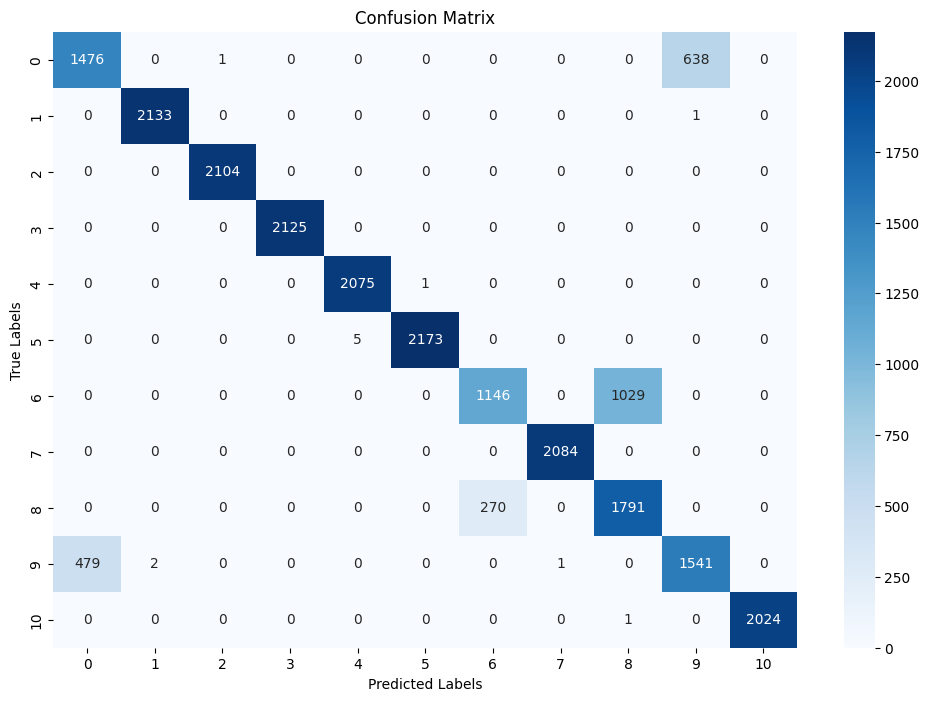

Model saved as 'best_catboost_model.pkl'


In [43]:
# Initialize the CatBoost model with specified hyperparameters
catboost_model = CatBoostClassifier(
    iterations=600,          # Number of boosting iterations
    learning_rate=0.09,       # Step size for each iteration
    depth=6,                 # Depth of the trees
    l2_leaf_reg=3,           # L2 regularization coefficient
    verbose=0,               # Suppress verbose output
    random_seed=42           # Fixed random state for reproducibility
)

# Fit the model to the training data
catboost_model.fit(X_train, y_train.argmax(axis=1))  # Use argmax to convert categorical back to labels

# Make predictions on the test data
y_pred = catboost_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test.argmax(axis=1), y_pred)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the best model to a file
joblib.dump(best_catboost_model, 'best_catboost_model.pkl')
print("Model saved as 'best_catboost_model.pkl'")

## 1. Convolutional Neural Network (CNN)

In [ ]:
# Reshape the data for CNN input
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define a function to build the CNN model with more hyperparameters
def build_cnn_model(hp):
    model = Sequential()
    
    model.add(Conv1D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32), 
                     kernel_size=hp.Int('kernel_size_1', min_value=3, max_value=5, step=1), 
                     activation=hp.Choice('activation_1', ['relu', 'tanh']), 
                     input_shape=(X_train_cnn.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv1D(filters=hp.Int('filters_2', min_value=32, max_value=128, step=32), 
                     kernel_size=hp.Int('kernel_size_2', min_value=3, max_value=5, step=1), 
                     activation=hp.Choice('activation_2', ['relu', 'tanh'])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), 
                    activation=hp.Choice('activation_dense', ['relu', 'tanh'])))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout', 0.2, 0.5, step=0.1)))
    
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    # Tuning learning rate and optimizer
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Initialize the Tuner for CNN using RandomSearch (with max_trials)
tuner_cnn = kt.RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=50,  # Set to 50 trials
    executions_per_trial=1,  # You can increase this for more robust evaluation
    directory='my_dir', 
    project_name='cnn_random_search'
)

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Search for the best hyperparameters using 40 epochs
tuner_cnn.search(X_train_cnn, y_train, 
                 epochs=10,  # Use 15 epochs for hyperparameter tuning
                 validation_split=0.2, 
                 callbacks=[early_stopping])

# Get the best CNN model
best_cnn_model = tuner_cnn.get_best_models(num_models=1)[0]

# Train the best model with 80 epochs
best_cnn_model.fit(X_train_cnn, y_train, 
                   epochs=80,  # Use 80 epochs for final training
                   validation_split=0.2, 
                   callbacks=[early_stopping])

# Evaluate the best CNN model
y_pred_cnn = best_cnn_model.predict(X_test_cnn)
y_pred_classes_cnn = y_pred_cnn.argmax(axis=1)

# Print Accuracy and Classification Report for CNN
print("CNN Best Model Accuracy:", accuracy_score(y_test.argmax(axis=1), y_pred_classes_cnn))
print("CNN Best Model Classification Report:\n", classification_report(y_test.argmax(axis=1), y_pred_classes_cnn))

# Confusion Matrix for CNN
conf_matrix_cnn = confusion_matrix(y_test.argmax(axis=1), y_pred_classes_cnn)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CNN with Hyperparameter Tuning')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()